# Using Centroid Distance as Ground Truth to Assess Sample Quality

Here we will investigate if we can measure the quality of a sample by creating category embeddings, and test every sample in terms of its distance with the class-wise cosine distance to the centroid.

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from tensorflow.keras import layers, models

Cosine distance is the matrix multiplication of two L2 normalized embeddings, one of which is transposed

In [2]:
def cosine_distance(embeddings, centroids):
    return 1 - tf.matmul(
        tf.math.l2_normalize(embeddings, axis=1), 
        tf.math.l2_normalize(centroids.astype(np.float32), axis=1), 
        transpose_b=True
        )

Loading the MNIST dataset

In [3]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.mnist.load_data()

Preprocessing

In [4]:
xtrain = xtrain.astype(np.float32)[..., None] / 255
xtest = xtest.astype(np.float32)[..., None] / 255

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain)).\
    shuffle(2048, reshuffle_each_iteration=True).\
    batch(256)

Making a custom `28 x 28` MobileNet architecture with 1 channel (skip this part)

In [6]:
def correct_pad(inputs, kernel_size):
    img_dim = 1
    input_size = inputs.get_shape().as_list()[img_dim:(img_dim + 2)]

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)

    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)

    correct = (kernel_size[0] // 2, kernel_size[1] // 2)

    return ((correct[0] - adjust[0], correct[0]),
            (correct[1] - adjust[1], correct[1]))

In [7]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [8]:
def MobileNetV2(input_shape,
                alpha=1.0,
                **kwargs):
    row_axis, col_axis = (0, 1)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    img_input = layers.Input(shape=input_shape)

    channel_axis = -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = layers.ZeroPadding2D(padding=correct_pad(img_input, 3),
                             name='Conv1_pad')(img_input)
    x = layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=3)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=4)
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    x = layers.ReLU(6., name='out_relu')(x)
    model = models.Model(img_input, x)
    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    channel_axis = -1

    in_channels = inputs.get_shape().as_list()[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    if block_id:
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    if stride == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(x, 3),
                                 name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               activation=None,
                               use_bias=False,
                               padding='same' if stride == 1 else 'valid',
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'depthwise_BN')(x)

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    x = layers.Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      activation=None,
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'project_BN')(x)

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x

That constitutes our backbone

In [9]:
backbone = MobileNetV2(input_shape=(28, 28, 1))

In [10]:
class EmbeddingModel(tf.keras.Model):
    def __init__(self, backbone):
        super(EmbeddingModel, self).__init__()
        self.backbone = backbone
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(256)
        self.normalize = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) 
    def call(self, x, training=None, **kwargs):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.dense(x)
        embedding = self.normalize(x)
        return embedding

The embedding model is the backbone, with an L2 normalized dense layer that will create embeddings.

In [11]:
model = EmbeddingModel(backbone)

Training params

In [12]:
compute_loss = tfa.losses.TripletSemiHardLoss()
optimizer = tf.optimizers.Adam(lr=0.0001)
loss = tf.metrics.Mean()
epoch = 0

In [13]:
model.build(input_shape=(None, 28, 28, 1))

In [14]:
model.load_weights('mnist_embeddings.hdf5')

Training loop, which won't stop until all the samples are correctly embedded, and further than the margin

In [15]:
while loss.result() or not epoch: 
    loss.reset_states()
    epoch += 1
    for x, y in train_ds:
        with tf.GradientTape() as tape:
            embedding = model(x, training=True)
            running_loss = compute_loss(y, embedding)
        gradients = tape.gradient(running_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        loss.update_state(running_loss)
    print(f'{epoch:=3d} {loss.result().numpy():=12.10f}')
    if not epoch % 50:
        optimizer.learning_rate.assign(optimizer.learning_rate / 10)

In [16]:
# model.save_weights('mnist_embeddings.hdf5')

In [17]:
train_embeddings = model.predict(xtrain)
test_embeddings = model.predict(xtest)

In [18]:
clf = NearestCentroid(metric='cosine')

Creating embeddings based on the training set

In [19]:
clf.fit(train_embeddings, ytrain)

c:\users\nicolas\anaconda3\envs\tfgpu\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


NearestCentroid(metric='cosine')

In [20]:
distances = cosine_distance(test_embeddings, clf.centroids_).numpy()

Here we should see samples that are close to the centroid, so they should be pretty prototypical, so they should be pretty.

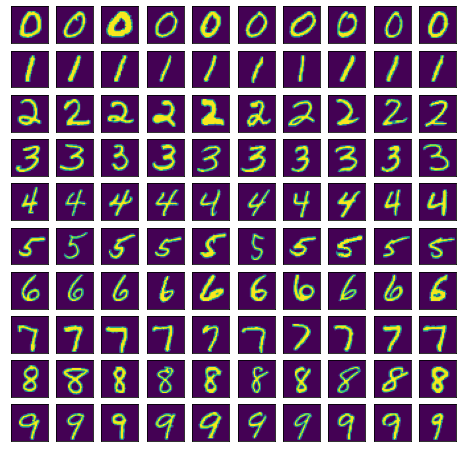

In [21]:
fig = plt.figure(figsize=(8, 8))
index = 0
for i in range(10):
    distances_subset = distances[:, i]
    distances_sorted = np.sort(distances_subset)
    image_index = np.argsort(distances_subset)
    for ix in range(10):
        fig.add_subplot(10, 10, index + 1)
        plt.imshow(xtrain[image_index[ix]])
        plt.xticks([]), plt.yticks([])
        index += 1
plt.show()

In [22]:
pca = PCA(n_components=2)
train_embeddings_reduced = pca.fit_transform(train_embeddings)
test_embeddings_reduced = pca.transform(test_embeddings)

In [23]:
nc = NearestCentroid(metric='cosine').fit(train_embeddings_reduced, ytrain)

c:\users\nicolas\anaconda3\envs\tfgpu\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


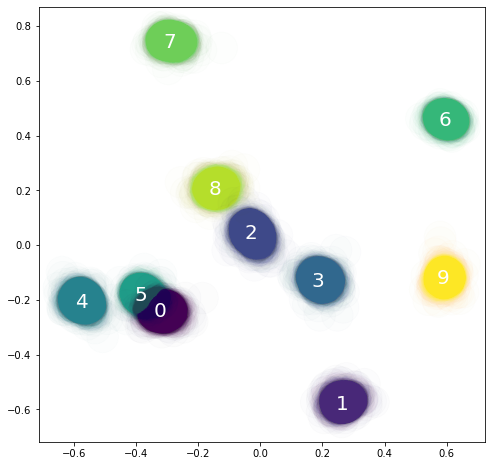

In [24]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(train_embeddings_reduced[:, 0], train_embeddings_reduced[:, 1], 
            c=ytrain, cmap='viridis', s=1000, alpha=.01)
for (x, y), string in zip(nc.centroids_, nc.predict(nc.centroids_)):
    plt.text(x - .025, y - .025, string, fontsize=20, color='w')
plt.show()

In [36]:
print(f'The explained variance with {pca.n_components} components is {sum(pca.explained_variance_):.2%}')

The explained variance with 3 components is 41.48%


Here, these are the samples that are the furthest from their centroid, so they should be atypical, or ugly/badly written.

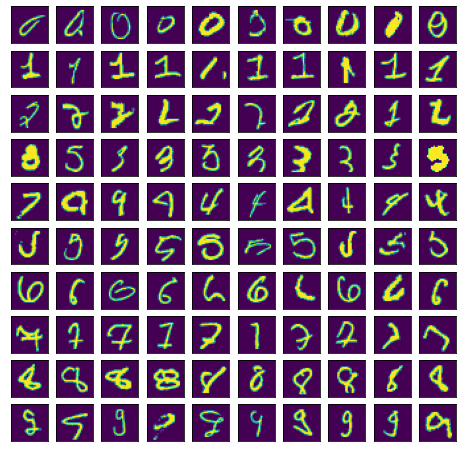

In [25]:
fig = plt.figure(figsize=(8, 8))
index = 0
for i in range(10):
    distances_subset = distances[:, i]
    subset_indices = np.argwhere(ytrain == i).ravel()
    distances_sorted = np.sort(distances_subset[subset_indices].ravel())[::-1]
    indices_sorted = np.argsort(distances_subset[subset_indices].ravel())[::-1]
    subset_pics = np.squeeze(xtrain[subset_indices])
    for ii in range(10):
        fig.add_subplot(10, 10, index + 1)
        plt.imshow(subset_pics[indices_sorted[ii]])
        plt.xticks([]), plt.yticks([])
        index += 1
plt.show()

It worked. Centroid distance from embeddings can be used to determine if a sample is of sufficient quality.

In [26]:
pca = PCA(n_components=3)
train_embeddings_reduced = pca.fit_transform(train_embeddings)
test_embeddings_reduced = pca.transform(test_embeddings)

In [27]:
nc = NearestCentroid(metric='cosine').fit(train_embeddings_reduced, ytrain)

c:\users\nicolas\anaconda3\envs\tfgpu\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


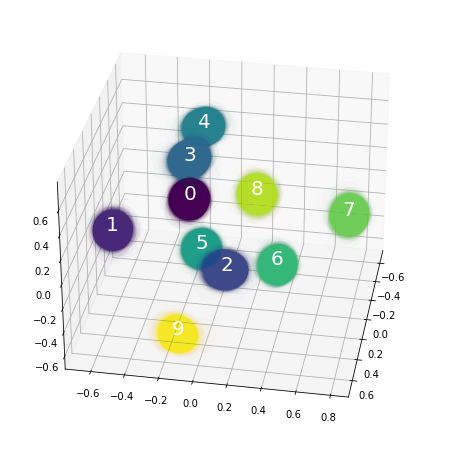

In [29]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 10)
ax.scatter(train_embeddings_reduced[:, 0], 
            train_embeddings_reduced[:, 1], 
            train_embeddings_reduced[:, 2], 
            c=ytrain, cmap='viridis', s=1000, alpha=.01)
for (x, y, z), string in zip(nc.centroids_, nc.predict(nc.centroids_)):
    ax.text(x - .05, y - .05, z - .05, s=string, fontsize=20, color='w')
plt.show()

In [36]:
print(f'The explained variance with {pca.n_components} components is {sum(pca.explained_variance_):.2%}')

The explained variance with 3 components is 41.48%
